In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# 使用随机森林模型

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

In [5]:
train = pd.read_csv("./data.csv")
test = pd.read_csv("./test.csv")
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [7]:
# 注意，Fare特征在train不缺，但在test中缺一个
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [8]:
# 筛选出有用的特征
predictors = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]

#对缺失值进行处理
train["Age"] = train["Age"].fillna(train["Age"].median())
test["Age"] = test["Age"].fillna(test["Age"].median())
test["Fare"] = test["Fare"].fillna(test["Fare"].median())

In [9]:
# 将字符转换为数字
train.loc[train["Sex"]=="male","Sex"] = 0
train.loc[train["Sex"]=="female","Sex"] = 1

test.loc[test["Sex"]=="male","Sex"] = 0
test.loc[test["Sex"]=="female","Sex"] = 1


#将上船地点转换为数字,缺失值用最多的“S”填充

train["Embarked"] = train["Embarked"].fillna('S')
train.loc[train["Embarked"] == "S", "Embarked"] = 0
train.loc[train["Embarked"] == "C", "Embarked"] = 1
train.loc[train["Embarked"] == "Q", "Embarked"] = 2

test.loc[test["Embarked"] == "S", "Embarked"] = 0
test.loc[test["Embarked"] == "C", "Embarked"] = 1
test.loc[test["Embarked"] == "Q", "Embarked"] = 2

In [10]:
print(train["Embarked"].unique())
print(test["Embarked"].unique())

[0 1 2]
[2 0 1]


In [11]:
X = train[predictors]
X.head(8)

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,0,22.0,1,0,7.2500,0
1,1,1,38.0,1,0,71.2833,1
2,3,1,26.0,0,0,7.9250,0
3,1,1,35.0,1,0,53.1000,0
4,3,0,35.0,0,0,8.0500,0
5,3,0,28.0,0,0,8.4583,2
6,1,0,54.0,0,0,51.8625,0
7,3,0,2.0,3,1,21.0750,0


In [12]:
y=train["Survived"]
y.describe()

count    891.000000
mean       0.383838
std        0.486592
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: Survived, dtype: float64

In [13]:
# 观察一下数据集在不调参数情况的效果
rfc = RandomForestClassifier(n_estimators=50,random_state=90)

score_pre = cross_val_score(rfc,X,y,cv=10).mean()

score_pre

0.8092883895131084

0.8126591760299624 161


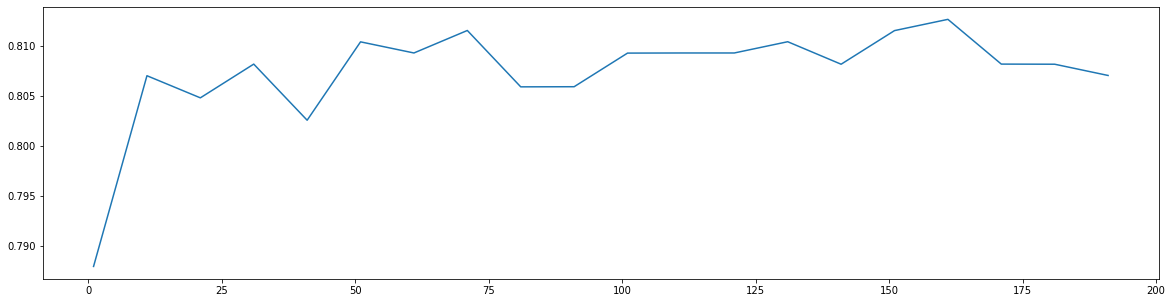

In [14]:
# 调节参数n_estimator
# 使用学习曲线来调节，因为可以观察趋势
scorel = []
for i in range(0,200,10):
    rfc = RandomForestClassifier(n_estimators=i+1,
                               n_jobs = -1,
                               random_state=90)
    score = cross_val_score(rfc,X,y,cv=10).mean()
    scorel.append(score)
    
print(max(scorel),(scorel.index(max(scorel))*10)+1)
plt.figure(figsize=[20,5])
plt.plot(range(1,201,10),scorel)
plt.show()

0.8137827715355804 162


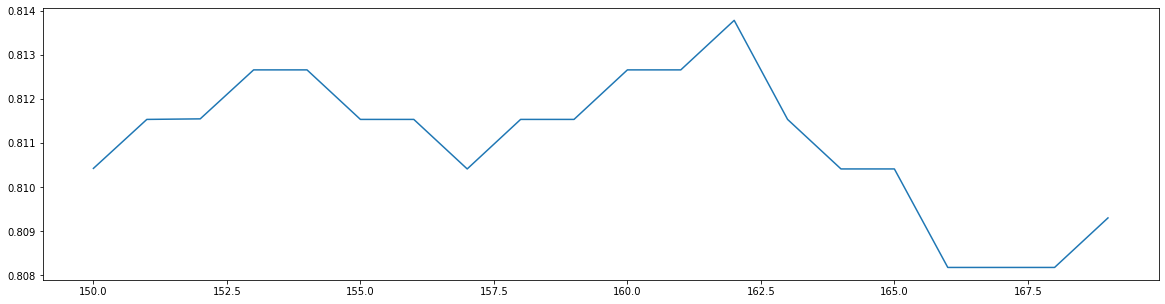

In [15]:
# 可以看出n_estimators取值161时效果最好
# 再缩小范围来一下
scorel = []
for i in range(150,170):
    rfc = RandomForestClassifier(n_estimators=i,
                                 n_jobs=-1,
                                 random_state=90)
    score = cross_val_score(rfc,X,y,cv=10).mean()
    scorel.append(score)
print(max(scorel),([*range(150,170)][scorel.index(max(scorel))]))
plt.figure(figsize=[20,5])
plt.plot(range(150,170),scorel)
plt.show()

#确定了某个较好的范围详细的来看一下

## 问题
- 我是对参数一个一个进行调试的，不同的参数组合肯定会相互影响
- 那么一个一个的调试对不对呢？
- 可以使用网格搜索一起调节吧！但是太消耗性能了
- 我的理解是调节一些参数后会增大或者减小模型的复杂度，依次来调节泛化误差到最低点

0.8384394506866416 9


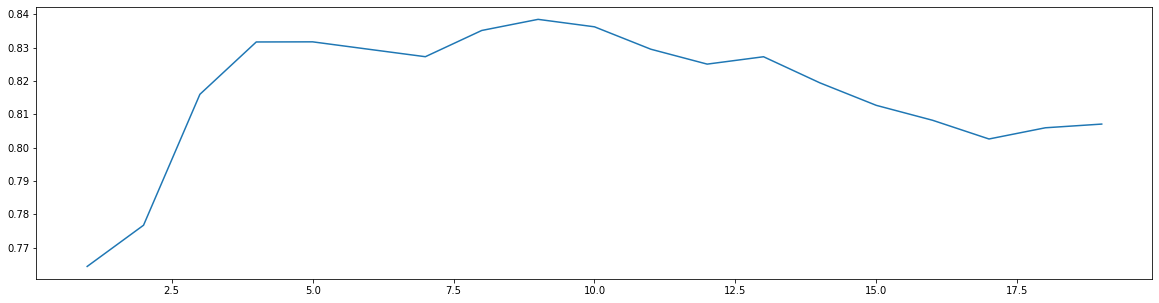

In [16]:
# 那n_estimators的值就取161
# n_estimators的值对随机森林的效果影响很大，理论上这个边界越大越好
# 接下来调节一下max_depth
scorel = []
for i in range(1,20):
    rfc = RandomForestClassifier(n_estimators=90,
                                 max_depth=i,
                                 n_jobs=-1,
                                 random_state=90)
    score = cross_val_score(rfc,X,y,cv=10).mean()
    scorel.append(score)
print(max(scorel),([*range(1,20)][scorel.index(max(scorel))]))
plt.figure(figsize=[20,5])
plt.plot(range(1,20),scorel)
plt.show()

0.8384394506866417 9


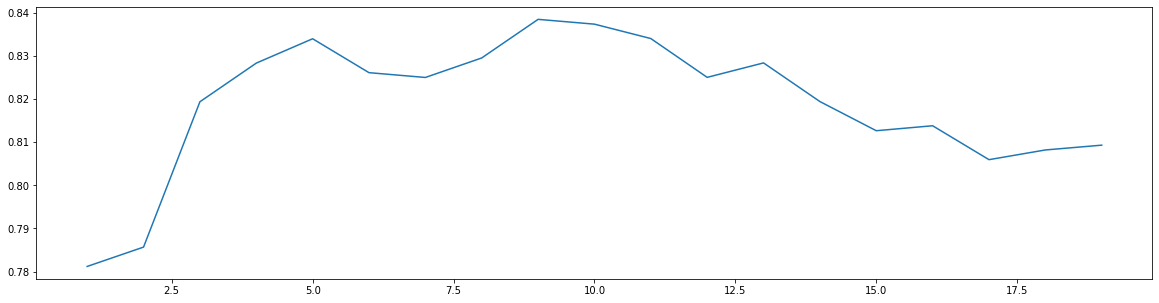

In [17]:
# n_estimators设置为90，来寻找最优的max_depth值为9
# 其最高分数达到了0.838，并且较稳定
# 我在尝试一下把n_estimators设置为162，估计max_depth的值会变小

scorel = []
for i in range(1,20):
    rfc = RandomForestClassifier(n_estimators=162,
                                 max_depth=i,
                                 n_jobs=-1,
                                 random_state=90)
    score = cross_val_score(rfc,X,y,cv=10).mean()
    scorel.append(score)
print(max(scorel),([*range(1,20)][scorel.index(max(scorel))]))
plt.figure(figsize=[20,5])
plt.plot(range(1,20),scorel)
plt.show()

## 分析
- max_depth的最优取值竟然还是9不变，和自己预期的不一样
- 自己上面的猜测可能有些错误，一个一个调参数可能没什么影响
- 上面参数要观察趋势，所以使用学习曲线

0.8384394506866417 2


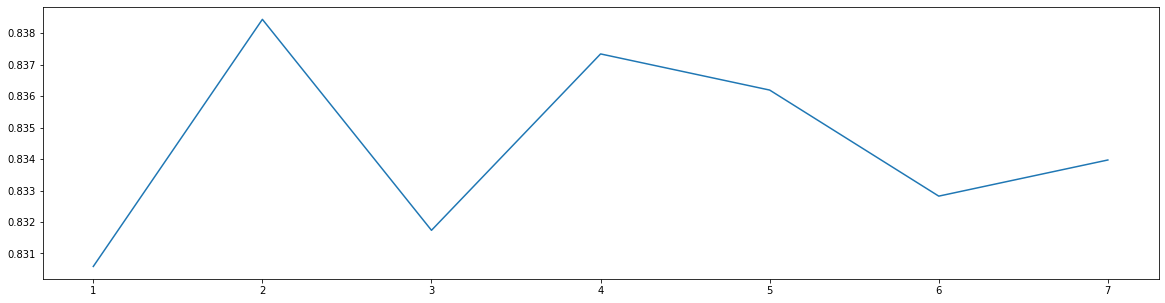

In [18]:
# 调整max_features,这个参数是唯一可以将模型往左或者往右退的参数
scorel = []
for i in range(1,8):
    rfc = RandomForestClassifier(n_estimators=162,
                                 max_depth=9,
                                 max_features=i,
                                 n_jobs=-1,
                                 random_state=90)
    score = cross_val_score(rfc,X,y,cv=10).mean()
    scorel.append(score)
print(max(scorel),([*range(1,8)][scorel.index(max(scorel))]))
plt.figure(figsize=[20,5])
plt.plot(range(1,8),scorel)
plt.show()

- 这个数据集选择了7个有用的特征，这个参数越小效果估计越差
- 选择的这7个特征对结果影响很大
---
- 结果是为2的时候最好，其次是为4的时候
- 我有点不信，再运行了一遍，曲线还是一样的
- 又猜错了,看来自己的没有经验
---
- 调整了这三个参数后，准确率最高为0.838，估计不用再调了
- 还可以调节max_sample_leaf和max_sample_split

In [20]:
# 看看最终参数交叉验证的打分
rfc = RandomForestClassifier(n_estimators=162,
                                 max_depth=9,
                                 max_features=2,
                                 n_jobs=-1,
                                 random_state=90)
score = cross_val_score(rfc,X,y,cv=10).mean()
score

0.8384394506866417

In [21]:
# 建立模型
rfc = RandomForestClassifier(n_estimators=162,
                                 max_depth=9,
                                 max_features=2,
                                 n_jobs=-1,
                                 random_state=90)
rfc = rfc.fit(X,y)

In [22]:
result = rfc.predict(test[predictors])

In [23]:
print(result)

[0 0 0 0 1 0 0 0 1 0 0 0 1 0 1 1 0 0 0 0 1 1 1 0 1 0 1 0 1 0 0 0 0 0 1 0 0
 0 0 1 0 1 0 1 1 0 0 0 1 1 0 0 1 1 0 0 0 0 0 1 0 0 0 1 1 1 1 0 0 1 1 0 0 0
 1 0 0 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 1 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0
 1 1 1 1 0 0 1 0 1 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0
 1 0 1 0 0 1 0 0 1 1 1 1 1 1 1 0 0 0 0 0 1 0 0 0 0 0 0 1 1 1 1 1 0 0 1 0 1
 0 1 0 0 0 0 0 1 0 1 0 1 0 0 0 1 1 0 1 0 0 0 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0
 1 0 1 1 0 1 0 0 0 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 1
 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 1 0 0
 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 1 0 0 0 1 0 1 0 0 1 0 1 1 0 1 0 0 0 1 0
 0 1 0 0 1 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 0 1 0 0 0 0
 0 1 1 1 1 0 0 1 0 0 0]


In [24]:
submission_df = pd.DataFrame(columns=['PassengerId', 'Survived'])
submission_df['PassengerId'] = test["PassengerId"]
submission_df['Survived'] = result
submission_df.to_csv('submissions.csv', header=True, index=False)
submission_df.head(20)

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
5,897,0
6,898,0
7,899,0
8,900,1
9,901,0


# 结果
- 得分：0.76315